In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt
from torch import Tensor, tensor

from pycox.models import CoxPH, CoxTime, DeepHitSingle
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv

from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.utils import concordance_index
warnings.simplefilter(action='ignore', category = FutureWarning)
warnings.simplefilter(action='ignore', category = RuntimeWarning)

In [2]:
def get_surv(model, x_test, timegrid = None):
    '''
    model: PyCox model class or compatibles
    x_test: covariate dataset to compute survival estimates
    timegrid: option to set upperbound of time grid to "Y" of training dataset
    '''
    warnings.simplefilter(action='ignore', category = FutureWarning)
    warnings.simplefilter(action='ignore', category = RuntimeWarning)
    
    x_train, target = model.training_data
    y_train, delta_train = target
    
    # compute residual from training data
    # exp_residual = np.nan_to_num(np.exp(np.log(y_train) - model.predict(x_train).reshape(-1)))

    # compute exp(-theta) from test data to evaluate accelerating component
    exp_predict = np.nan_to_num(np.exp(-model.predict(x_test)).reshape(-1))
    
    # estimate cumulative baseline hazard function
    # based on training dataset
    H = NelsonAalenFitter().fit(y_train, event_observed = delta_train).cumulative_hazard_
    
    # extract timegrid and estimated hazards
    if timegrid == "train":
        max_time = y_train.max()
    else:
        max_time = max(H.index)
    
    if H.shape[0] * exp_predict.shape[0] >= 6 * 10e7:        
        l = round(6 * 10e7 / exp_predict.shape[0])
        time_grid = np.quantile(a = H.loc[H.index <= max_time].index.values,
                                q = [i / l for i in range(l + 1)],
                                interpolation = 'nearest')
    else:
        time_grid = H.loc[H.index <= max_time].index.values
    
    H_base = H.loc[time_grid].values.reshape(-1)
    
    h_base = H_base[1:] - H_base[:-1]
    h_base = np.repeat(h_base.reshape(-1, 1), exp_predict.shape[0], axis = 1)
    
    # evaluate conditional cumulative hazard estimates
    # based on test dataset
    surv = pd.DataFrame(np.exp(-np.cumsum(h_base * exp_predict, axis = 0)),
                        index = time_grid[1:],
                        columns = [i for i in range(exp_predict.shape[0])])
    
    surv.index.names = ["duration"]
    
    return surv

In [3]:
def get_surv_residual(model, x_test, timegrid = None):
    '''
    model: PyCox model class or compatibles
    x_test: covariate dataset to compute survival estimates
    timegrid: option to set upperbound of time grid to "Y" of training dataset
    '''
    warnings.simplefilter(action='ignore', category = FutureWarning)
    warnings.simplefilter(action='ignore', category = RuntimeWarning)
    
    x_train, target = model.training_data
    y_train, delta_train = target
    
    # compute residual from training data
    exp_residual = np.nan_to_num(np.exp(np.log(y_train) - model.predict(x_train).reshape(-1)))

    # compute exp(-theta) from test data to evaluate accelerating component
    exp_predict = np.nan_to_num(np.exp(-model.predict(x_test)).reshape(-1))
    
    # estimate cumulative baseline hazard function
    # based on training dataset
    H = NelsonAalenFitter().fit(exp_residual, event_observed = delta_train).cumulative_hazard_
    
    # extract timegrid and estimated hazards
    if timegrid == "train":
        max_time = y_train.max()
    else:
        max_time = max(H.index)
    
    if H.shape[0] * exp_predict.shape[0] >= 6 * 10e7:        
        l = round(6 * 10e7 / exp_predict.shape[0])
        time_grid = np.quantile(a = H.loc[H.index <= max_time].index.values,
                                q = [i / l for i in range(l + 1)],
                                interpolation = 'nearest')
    else:
        time_grid = H.loc[H.index <= max_time].index.values
    
    H_base = H.loc[time_grid].values.reshape(-1)
    
    h_base = H_base[1:] - H_base[:-1]
    h_base = np.repeat(h_base.reshape(-1, 1), exp_predict.shape[0], axis = 1)
    
    # evaluate conditional cumulative hazard estimates
    # based on test dataset
    surv = pd.DataFrame(np.exp(-np.cumsum(h_base * exp_predict, axis = 0)),
                        index = time_grid[1:],
                        columns = [i for i in range(exp_predict.shape[0])])
    
    surv.index.names = ["duration"]
    
    return surv

In [80]:
## DSAFT - rank loss function
def dsaft_rank_loss(theta, durations, events, weight = None, alpha = 0.0, beta = 0.0, gamma = 0.0, delta = 0.0):
    '''
    theta: prediction output from DNN layers
    durations: log-scaled observed time (log(Y))
    events: right-censoring-indicator (delta)
    '''
    n = durations.shape[0]
    
    # compute residual e_i
    e = theta.sub(durations.view(-1,1).add(1e-32).log()).neg()
    
    # evaluate loss function based on formula,
    # mul(1 / e_vector.shape[0] ** 2) : scaling constant
    
    loss = e.sub(e.view(-1)).mul(e.sub(e.view(-1))<=0).abs().mul(events.view(-1,1)).sum().mul(1 / n ** 2)
    
    # penalty_1 = e.abs().sub(e).div(2).pow(2).mul(events.sub(1).abs()).sum().div(n).mul(alpha)
    # penalty_2 = e.pow(2).mul(events).sum().div(n).mul(beta)
    
    penalty_1 = e.abs().add(e).div(2).pow(2).sum().div(n).mul(alpha)
    penalty_2 = e.pow(2).sum().div(n).mul(beta)
    penalty_3 = theta.pow(2).sum().div(n).mul(gamma)
    
#    grid_size = 1000
    
#    if n < 1000:
#        grid_size = n
        
#    grid = np.round(np.linspace(0, grid_size - 1, 1000))
#    t = theta[grid]
#    y = durations[grid]
#    d = events[grid]
    
#    first = t.neg().exp().neg().exp().pow(2).view(-1).mul(d.mul(y.view(-1,1).sub(y) >= 0)).sum(1)
#    second = t.neg().exp().neg().exp().sub(1).neg().pow(2).view(-1).mul(y.view(-1,1).sub(y) < 0).sum(1)
#    penalty_4 = first.add(second).sum().div(grid_size).mul(delta)
    
    return loss + penalty_1 + penalty_2 + penalty_3


## Classes below
class DSAFTRankLoss(torch.nn.Module):
    def __init__(self, weight = None, alpha = 0.0, beta = 0.0, gamma = 0.0, delta = 0.0):
        super(DSAFTRankLoss, self).__init__()
        self.weight = weight
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
    def forward(self, log_h: Tensor, durations: Tensor, events: Tensor) -> Tensor:
        return dsaft_rank_loss(log_h, durations, events, weight = self.weight,
                               alpha = self.alpha, beta = self.beta,
                               gamma = self.gamma, delta = self.delta)

In [81]:
np.random.seed(1234)
torch.manual_seed(1234)
frac = 1.0

from kkbox import _DatasetKKBoxChurn
kkbox_v1 = _DatasetKKBoxChurn()
df_train = kkbox_v1.read_df(subset='train').sample(frac = frac)
df_val = kkbox_v1.read_df(subset='val').sample(frac = frac)
df_test = kkbox_v1.read_df(subset='test').sample(frac = frac)

df_train["gender"].replace('male', 1, inplace=True)
df_train["gender"].replace('female', 2, inplace=True)
df_train["gender"].replace(np.NaN, 0, inplace=True)

df_val["gender"].replace('male', 1, inplace=True)
df_val["gender"].replace('female', 2, inplace=True)
df_val["gender"].replace(np.NaN, 0, inplace=True)

df_test["gender"].replace('male', 1, inplace=True)
df_test["gender"].replace('female', 2, inplace=True)
df_test["gender"].replace(np.NaN, 0, inplace=True)

In [82]:
cols_standardize = ['n_prev_churns', 'log_days_between_subs', 'log_days_since_reg_init' ,'age_at_start', 'log_payment_plan_days', 'log_plan_list_price', 'log_actual_amount_paid']
cols_leave = ['is_auto_renew', 'is_cancel', 'strange_age', 'nan_days_since_reg_init', 'no_prev_churns']
        
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [83]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [84]:
_ = np.nan_to_num(x_train,copy=False)
_ = np.nan_to_num(x_val,copy=False)
_ = np.nan_to_num(x_test,copy=False)

In [85]:
def replace_zero(duration):
    return np.where(duration <= 0.0, duration + np.sort(np.unique(duration))[1], duration)

In [86]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
val = x_val, y_val

durations_test, events_test = get_target(df_test)

labtrans = CoxTime.label_transform()

y_train_transformed = labtrans.fit_transform(*get_target(df_train))
y_train_transformed = (np.exp(y_train_transformed[0]), y_train_transformed[1])
y_val_transformed = labtrans.transform(*get_target(df_val))
y_val_transformed = (np.exp(y_val_transformed[0]), y_val_transformed[1])
val_transformed = x_val, y_val_transformed
durations_test_transformed, events_test = labtrans.transform(*get_target(df_test))
durations_test_transformed = np.exp(durations_test_transformed)

In [87]:
train_log_replace = np.log(replace_zero(y_train[0])).reshape(-1, 1)
val_log_replace = np.log(replace_zero(y_val[0])).reshape(-1, 1)

scaler_train = StandardScaler().fit(train_log_replace)

y_train_transformed = (np.exp(scaler_train.transform(train_log_replace).reshape(-1)), y_train[1])
y_val_transformed = (np.exp(scaler_train.transform(val_log_replace).reshape(-1)), y_val[1])

val_transformed = x_val, y_val_transformed

test_log_replace = np.log(replace_zero(durations_test)).reshape(-1, 1)
durations_test_transformed = np.exp(scaler_train.transform(test_log_replace).reshape(-1))

In [101]:
in_features = x_train.shape[1]
num_layers = 8
num_node = 512
num_nodes = [num_node] * num_layers
out_features = 1
batch_norm = True
dropout = 0.0
output_bias = False
batch_size = 4096
# lr = 0.001
lr = 1e-3
wd = 0.0
alpha = 0.0
beta = 1e-7
gamma = 1e-7
delta = 0.0

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

lr = 0.00005
wd = 0.0
alpha = 0.000001
beta = 0.000001

In [102]:
model = CoxPH(net, optimizer=tt.optim.AdamWR(lr = lr, decoupled_weight_decay = wd))
model.loss = DSAFTRankLoss(alpha = alpha, beta = beta, gamma = gamma, delta = delta)

In [103]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(checkpoint_model = False, load_best = False)]
verbose = True

In [104]:
%%time
log = model.fit(x_train, y_train_transformed, batch_size, epochs, callbacks, verbose,
                val_data = val_transformed, val_batch_size = batch_size)

0:	[16s / 16s],		train_loss: 0.2031,	val_loss: 0.1966
1:	[16s / 33s],		train_loss: 0.1996,	val_loss: 0.1988
2:	[16s / 50s],		train_loss: 0.1962,	val_loss: 0.1959
3:	[16s / 1m:6s],		train_loss: 0.1983,	val_loss: 0.1992
4:	[16s / 1m:23s],		train_loss: 0.1968,	val_loss: 0.1969
5:	[17s / 1m:40s],		train_loss: 0.1957,	val_loss: 0.1957
6:	[16s / 1m:57s],		train_loss: 0.1947,	val_loss: 0.1951
7:	[16s / 2m:14s],		train_loss: 0.1968,	val_loss: 0.1972
8:	[16s / 2m:31s],		train_loss: 0.1963,	val_loss: 0.1973
9:	[16s / 2m:48s],		train_loss: 0.1957,	val_loss: 0.1965
10:	[17s / 3m:5s],		train_loss: 0.1953,	val_loss: 0.1958
11:	[16s / 3m:22s],		train_loss: 0.1949,	val_loss: 0.1954
12:	[16s / 3m:39s],		train_loss: 0.1944,	val_loss: 0.1949
13:	[16s / 3m:55s],		train_loss: 0.1939,	val_loss: 0.1945
14:	[16s / 4m:12s],		train_loss: 0.1937,	val_loss: 0.1944
15:	[16s / 4m:29s],		train_loss: 0.1956,	val_loss: 0.1966
16:	[16s / 4m:46s],		train_loss: 0.1954,	val_loss: 0.1968
17:	[17s / 5m:3s],		train_loss: 0.1

## CoxTime

In [16]:
labtrans = CoxTime.label_transform()
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)

In [17]:
in_features = x_train.shape[1]
num_layers = 8
num_node = 256
num_nodes = [num_node] * num_layers
out_features = 1
batch_norm = True
dropout = 0.0
output_bias = False
batch_size = 4096

In [18]:
net2 = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

In [19]:
model2 = CoxTime(net2, labtrans = labtrans)
model2.optimizer.set_lr(0.0001)

In [20]:
epochs = 50
callbacks2 = [tt.callbacks.EarlyStopping(checkpoint_model = False, load_best = False)]
verbose = True

In [21]:
%%time
log2 = model2.fit(x_train, y_train, batch_size, epochs, callbacks2, verbose,
                  val_data = val.repeat(10).cat())

0:	[50s / 50s],		train_loss: 0.3592,	val_loss: 0.3418
1:	[31s / 1m:21s],		train_loss: 0.3337,	val_loss: 0.3323
2:	[31s / 1m:53s],		train_loss: 0.3281,	val_loss: 0.3261
3:	[34s / 2m:27s],		train_loss: 0.3241,	val_loss: 0.3229
4:	[32s / 2m:59s],		train_loss: 0.3212,	val_loss: 0.3199
5:	[31s / 3m:30s],		train_loss: 0.3184,	val_loss: 0.3184
6:	[32s / 4m:3s],		train_loss: 0.3163,	val_loss: 0.3164
7:	[32s / 4m:35s],		train_loss: 0.3146,	val_loss: 0.3135
8:	[31s / 5m:7s],		train_loss: 0.3131,	val_loss: 0.3127
9:	[32s / 5m:39s],		train_loss: 0.3121,	val_loss: 0.3147
10:	[32s / 6m:12s],		train_loss: 0.3105,	val_loss: 0.3106
11:	[34s / 6m:47s],		train_loss: 0.3094,	val_loss: 0.3104
12:	[30s / 7m:17s],		train_loss: 0.3091,	val_loss: 0.3116
13:	[30s / 7m:47s],		train_loss: 0.3076,	val_loss: 0.3106
14:	[33s / 8m:20s],		train_loss: 0.3073,	val_loss: 0.3080
15:	[33s / 8m:54s],		train_loss: 0.3062,	val_loss: 0.3071
16:	[31s / 9m:25s],		train_loss: 0.3055,	val_loss: 0.3053
17:	[31s / 9m:57s],		train_lo

In [22]:
%%time
_ = model2.compute_baseline_hazards()
surv_cox = model2.predict_surv_df(x_test)
ev_cox = EvalSurv(surv_cox, durations_test, events_test, censor_surv='km')

Wall time: 15min 12s


In [23]:
%%time
bs_cox = ev_cox.brier_score(time_grid)

Wall time: 1.48 s


In [174]:
def get_scores(model, y_test, delta_test, time_grid, surv_residual = False, cens_residual = False):
    n = y_test.shape[0]
    x_train, target = model.training_data
    y_train, delta_train = target

    # compute residual from training data
    exp_residual_train = np.nan_to_num(np.exp(np.log(y_train) - model.predict(x_train).reshape(-1)))
    exp_residual_test = np.nan_to_num(np.exp(np.log(y_test) - model.predict(x_test).reshape(-1)))

    # compute exp(-theta) from test data to evaluate accelerating component
    exp_predict_neg_test = np.nan_to_num(np.exp(-model.predict(x_test)).reshape(-1))

    naf_base = NelsonAalenFitter().fit(y_train, event_observed = delta_train)
    kmf_cens = KaplanMeierFitter().fit(y_train, event_observed = 1 - delta_train)
    
    if cens_residual == True:
        cens_test = kmf_cens.survival_function_at_times(exp_residual_test)
    elif cens_residual == False:
        cens_test = kmf_cens.survival_function_at_times(y_test)

    # if surv_residual == True:
    #     naf_base = NelsonAalenFitter().fit(exp_residual, event_observed = delta_train)
    # elif surv_residual == False:
    #     naf_base = NelsonAalenFitter().fit(y_train, event_observed = delta_train)
        
    # if cens_residual == True:
    #     kmf_cens = KaplanMeierFitter().fit(exp_residual, event_observed = 1 - delta_train)
    #     cens_test = kmf_cens.survival_function_at_times(np.nan_to_num(np.exp(np.log(y_test) - model.predict(x_test).reshape(-1))))
    # elif cens_residual == False:
    #     kmf_cens = KaplanMeierFitter().fit(y_train, event_observed = 1 - delta_train)
    #     cens_test = kmf_cens.survival_function_at_times(y_test)

    bss = []
    nblls = []
    for t in time_grid:
        bs, nbll = get_score(n, t, y_test, delta_test, naf_base, kmf_cens, cens_test, exp_predict_neg_test, surv_residual, cens_residual, model)
        bss.append(bs)
        nblls.append(nbll)

    return (np.array(bss), np.array(nblls))

In [175]:
def get_score(n, t, y_test, delta_test, naf_base, kmf_cens, cens_test, exp_predict_neg_test, surv_residual, cens_residual, model):
    exp_residual_t = np.nan_to_num(np.exp(np.repeat(np.log(t),n) - model.predict(x_test).reshape(-1)))
    
    if surv_residual == True:
        H_base = naf_base.cumulative_hazard_at_times(exp_residual_t).values
    elif surv_residual == False:
        H_base = naf_base.cumulative_hazard_at_times(t).values        
    
    if cens_residual == True:
        cens_t = kmf_cens.survival_function_at_times(exp_residual_t).values
    elif cens_residual == False:
        cens_t = np.repeat(kmf_cens.survival_function_at_times(t).values, n)

    surv_cond = np.exp(-(H_base * exp_predict_neg_test)) - 1e-32
    
    indicator_first = (y_test <= t) * delta_test
    indicator_second = (y_test > t) * 1

    first_bs = np.power(surv_cond, 2) * indicator_first / cens_test
    second_bs = np.power(1 - surv_cond, 2) * indicator_second / cens_t
    bs = (first_bs + second_bs).sum() / n
    
    first_nbll = np.nan_to_num(np.log(1 - surv_cond)) * indicator_first / cens_test
    second_nbll = np.nan_to_num(np.log(surv_cond)) * indicator_second / cens_t
    nbll = np.nan_to_num((first_nbll + second_nbll).sum()) / n
    
    return (bs, nbll)

In [208]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
time_grid_dsaft = np.exp(scaler_train.transform(np.log(time_grid.reshape(-1, 1)))).reshape(-1)
#time_grid_dsaft = np.linspace(durations_test_transformed.min(), durations_test_transformed.max(), 100)

In [177]:
%%time
bs_residual, nbll_residual = get_scores(model, durations_test_transformed, events_test, time_grid_dsaft, surv_residual = True, cens_residual = True)

Wall time: 1min 39s


In [178]:
nbll_cox = ev_cox.nbll(time_grid)

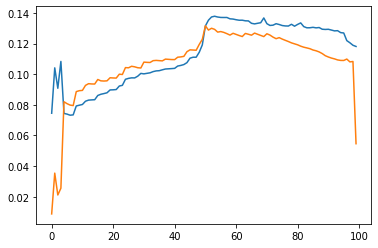

In [179]:
_ = plt.plot(bs_residual)
_ = plt.plot(bs_cox.values)

In [180]:
ds_cox = np.repeat(time_grid[1] - time_grid[0], 100)
ds_dsaft = np.array(time_grid_dsaft - np.array([0.0] + time_grid_dsaft[:-1].tolist()))

In [29]:
c_coxtime = ev_cox.concordance_td()

In [181]:
c_dsaft = concordance_index(durations_test_transformed, model.predict(x_test).reshape(-1),
                            event_observed = events_test)

In [182]:
print("IBS (Cox-Time):             {}".format((bs_cox * ds_cox).sum() / (time_grid.max() - time_grid.min())))
print("IBS (DSAFT - residual):     {}".format((bs_residual * ds_dsaft).sum() / (time_grid_dsaft.max() - time_grid_dsaft.min())))
#print("IBS (DSAFT - residual):     {}".format((bs_residual * ds_dsaft).sum() / (time_grid.max() - time_grid.min())))

IBS (Cox-Time):             0.1086882435189325
IBS (DSAFT - residual):     0.10817903737265046


In [183]:
print("Ctd (Cox-Time):             {}".format(c_coxtime))
print("Ctd (DSAFT - residual):     {}".format(c_dsaft))

Ctd (Cox-Time):             0.859193740903564
Ctd (DSAFT - residual):     0.8643834869652312


In [184]:
print("IBS (Cox-Time):             {}".format((nbll_cox * ds_cox).sum() / (time_grid.max() - time_grid.min())))
print("IBS (DSAFT - residual):     {}".format((nbll_residual * ds_dsaft).sum() / (time_grid_dsaft.max() - time_grid_dsaft.min())))
#print("IBS (DSAFT - residual):     {}".format((bs_residual * ds_dsaft).sum() / (time_grid.max() - time_grid.min())))

IBS (Cox-Time):             0.3349991585472528
IBS (DSAFT - residual):     -5.233628961391219e+300
